In [2]:
import os
os.getcwd()
os.chdir('/home/a4ankan/aMAZON fINAL WORK/amazon fine food')
os.getcwd()

'/home/a4ankan/aMAZON fINAL WORK/amazon fine food'

Amazon Fine Food Reviews Analysis
----------------------------------------------------

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

Attribute Information:

    Id
    ProductId - unique identifier for the product
    UserId - unqiue identifier for the user
    ProfileName
    HelpfulnessNumerator - number of users who found the review helpful
    HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    Score - rating between 1 and 5
    Time - timestamp for the review
    Summary - brief summary of the review
    Text - text of the review

Objective:

Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


Loading the Data
-----------------------

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle



# it connects my code with the sql database
con = sqlite3.connect('database.sqlite') 



#Writting a query; 'con' is the link
# Here, I am saying that 'slelct (*) from reviews which are not equal to 3'.
#Just take the reviews which are 1,2,4 or 5.



filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) #filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3


# here, due to memory issues i am taking only 4000 reviews that i would work with

filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
LIMIT 4000
""", con)



# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

print(filtered_data.shape) #The score coloumn becomesb positive / negative
filtered_data.head()

(4000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Data Cleansing : deduplication
---------------------------------------------

(1) It is based more on how we observe or interpret the data. 
(2) Basically it is cleaning or filtering the data.

we don't want to feed grbage to our model.. Do we?
--------------------------------------------------------------------------
So we remove duplicates from our entry

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(3988, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.7

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)



display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


Observations:
---------

1) Same User(Geetha Krishnan) has multiple reviews ofwith the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text





2) It is inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it is decided to eliminate the rows having same parameters.
3) The method used for the removing the redundancy is to first sort the data according to ProductId and then just keep the first similar product review and delelte the others

In [8]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(3988, 10)


positive    3386
negative     602
Name: Score, dtype: int64

In [10]:
filtered_data[['Summary','Score','Text']].head()

,Summary,Score,Text
0,Good Quality Dog Food,positive,I have bought several of the Vitality canned d...
1,Not as Advertised,negative,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",positive,This is a confection that has been around a fe...
3,Cough Medicine,negative,If you are looking for the secret ingredient i...
4,Great taffy,positive,Great taffy at a great price. There was a wid...


How to convert Text to Vector?? Text Preprocessing: Stemming, stop-word removal and Lemmatization.
-------------



Here, we determine a review by score. But what if a user had mistakernly put a 5 star review but was not at all satisfied with the product? We might find such cases so the most importrant factor in determining the outcome of a review is either the text of the review or the summary text.

Begin by removing the html tags
Remove any punctuations or limited set of special characters like , or . or # etc.
Check if the word is made up of english letters and is not alpha-numeric
Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
Convert the word to lowercase
Remove Stopwords
Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
After which we collect the words used to describe positive and negative review


In [11]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [12]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'myself', "needn't", 'won', 'between', 'o', 'above', 'down', 'himself', "aren't", 'were', 'few', 'i', "you've", 'of', 'whom', 'hasn', 'do', 's', 'mightn', 're', 'been', "she's", 'by', 'than', "hadn't", 'his', "haven't", 'couldn', 've', 'there', 't', 'you', 'same', 'if', 'other', "weren't", "you're", 'for', 'further', 'with', "should've", "isn't", 'herself', 'those', "you'd", 'ours', 'over', 'under', 'or', 'these', 'as', 'some', 'he', 'while', 'how', 'during', 'itself', 'until', 'up', 'my', 'once', 'them', 'we', 'each', "couldn't", 'own', 'mustn', 'they', "that'll", 'm', 'had', 'themselves', 'that', 'haven', 'after', 'and', 'in', 'all', 'against', 'a', 'just', 'such', 'should', 'don', 'hers', 'was', 'its', "don't", 'any', "doesn't", "wouldn't", 'being', "it's", 'about', 'ma', "mightn't", 'can', 'having', 'yourself', 'below', "hasn't", 'because', 'this', 'have', 'not', 'very', 'when', 'here', 'at', 'doing', 'isn', 'doesn', 'didn', 'an', 'wasn', 'more', 'it', 'now', 'hadn', 'yours', "won

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase

i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1
    

Observation:
--------

All stopwords and gtml tags have been removed.

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [15]:

# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [15]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2774,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,positive,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
2773,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,positive,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
1243,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...


In [16]:
print(final.shape)

(3988, 11)


Bag Of Words (BoW) :
-----------

Bag of Words constructs a dictionsry of all the words in the document. A corpous is defined as a set of documents/reviews.
It converts all the words in the document into a vector each word having a different dimension. Each cell in the vector corresponds to the no of times a word occurs in the document.
 Similar texts result in closer distances between two vectors. Although BoW has its own limitations.


In [17]:
#BoW

count_vect = CountVectorizer(max_features= 7553).fit(final)
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (3988, 7553)
the number of unique words  7553


In [18]:
print(final.shape)

(3988, 11)


In [19]:
from sklearn.manifold import TSNE

data_2000 = final_counts[0:3998,:] #picking the first 4k points and putting it in  data_2000
top_2000 = data_2000.toarray() #converting data_2000 to an array
labels = final['Score'] # Defining labels 
labels_2000 = labels[0:3998] # taking first 4k labsls and putting it in labels_2000

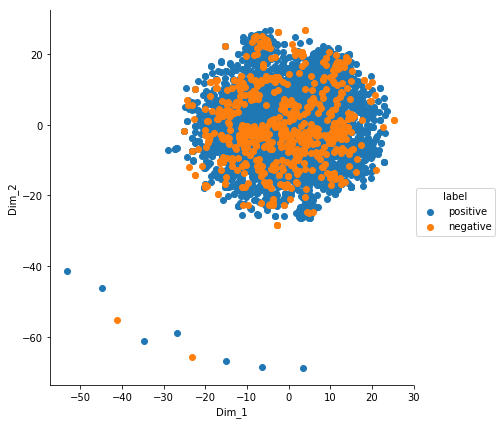

fig 1
tSNE: with default perplexity = 30 & no. of iterations = 1000


In [20]:




model = TSNE(n_components=2, random_state=0) # Defining the model... no of cokmponents  = 2 and random state = 0
tsne_data = model.fit_transform(top_2000) # Takes 5k points and crfeates my tsne data

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T # We combine the tsne data with labels using v stack
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label")) # tnse data to dataframe with 1st col as 'dim1' second as 'dim2 ' 3rd as 'label'

    # Ploting the result of tsne


sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()

plt.show()

print('fig 1')
print('tSNE: with default perplexity = 30 & no. of iterations = 1000')



Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

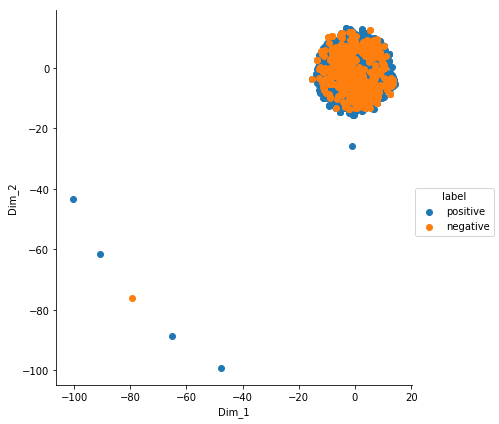

fig 2
tSNE: with default perplexity = 50 & no. of iterations = 5000


In [21]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000) #preplexity changed with no. of iterations
tsne_data = model.fit_transform(top_2000)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 2')
print('tSNE: with default perplexity = 50 & no. of iterations = 5000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

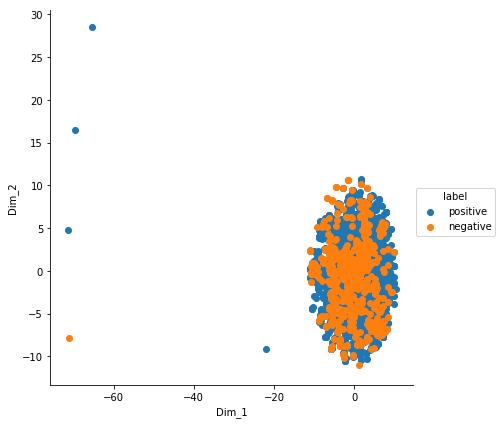

fig 3
tSNE: with default perplexity = 65 & no. of iterations = 5000


In [20]:
model = TSNE(n_components=2, random_state=0, perplexity=65,  n_iter=5000) #preplexity changed with no. of iterations
tsne_data = model.fit_transform(top_2000)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 3')
print('tSNE: with default perplexity = 65 & no. of iterations = 5000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

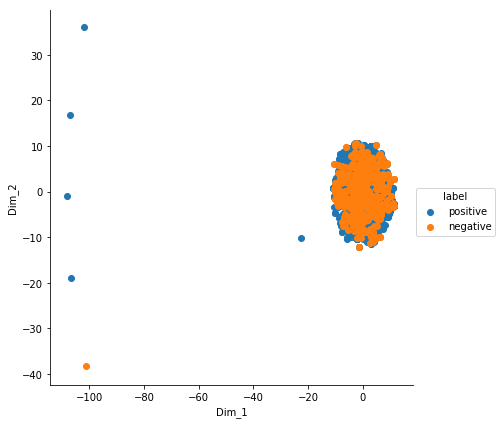

fig 4
tSNE: with default perplexity = 60 & no. of iterations = 75000


In [23]:
model = TSNE(n_components=2, random_state=0, perplexity=60,  n_iter=75000) #preplexity changed with no. of iterations
tsne_data = model.fit_transform(top_2000)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 4')
print('tSNE: with default perplexity = 60 & no. of iterations = 75000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

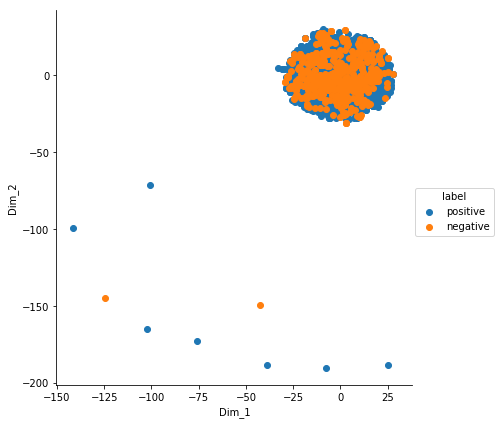

fig 5
tSNE: with default perplexity = 30 & no. of iterations = 55000


In [24]:
model = TSNE(n_components=2, random_state=0, perplexity=30,  n_iter=55000) #preplexity changed with no. of iterations
tsne_data = model.fit_transform(top_2000)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 5')
print('tSNE: with default perplexity = 30 & no. of iterations = 55000')

Observation:
------------------

Same like before, we can see a very unplesant plot.

Result:
-----------

We can clearly say form the above plot that even after changing the perplexity and the no of iterations, we don't find any satisfactions. So, the result is inconcluusive. One interesting feature is that we se that all the positive and the negative points overlap. with fig1 having a bit less overlap

tf & idf: Term frequency & Inverse document frequency
-------------

1) TF of any word in any document is defined as the (no of times the word occurs in the document) / (Total no of words in the document) TF(w,r) = # (w in r)/ Total # of words in r

2) The tf lies between (0,1)... it is basically a proability of finding a word in a document.

3) Idf is defined as the total no of reviews/ no of reviews that contain a particular word.

4) It is a log function, which means it can be monotonically increasing or decreasing.


TfIDF combination:
------------
 
    The main objective here is to give weightage to words which are rare in a corpus but are more important, that is occur more frequently in my document
    
                    TF(W,R)*IDF(W,D)

In [25]:
final = final[0 : 4000] 
print(final.shape)

(3988, 11)


In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3988, 99939)
the number of unique words including both unigrams and bigrams  99939


In [27]:
from scipy.sparse import csr_matrix
A = csr_matrix(final_tf_idf)
print(A.shape)

B = A.toarray()
print(B.shape)

(3988, 99939)
(3988, 99939)


In [28]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(B)
print(standardized_data.shape)

(3988, 99939)


In [29]:
data_2000 = final_counts[0:4000,:] #picking the first 4k points and putting it in  data_2000
top_2000 = data_2000.toarray() #converting data_2000 to an array
labels = final['Score'] # Defining labels 
labels_2000 = labels[0:4000] # taking first 4k labsls and putting it in labels_2000


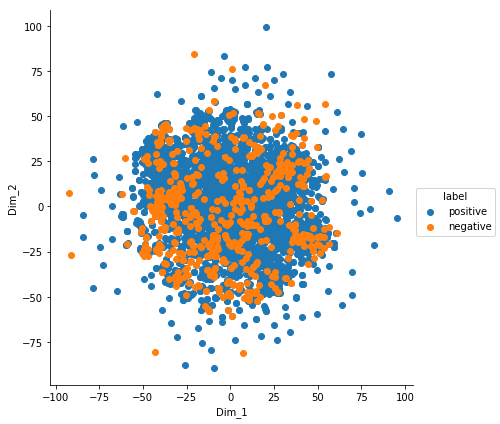

fig 6
tSNE: with default perplexity  & no. of iterations


In [30]:
model = TSNE(n_components=2,random_state=0,) #preplexity with default no. of iterations and perplexity
tsne_data = model.fit_transform(B)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 6')
print('tSNE: with default perplexity  & no. of iterations')





Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

 tSNE: with p =50 and number of iterations = 5k


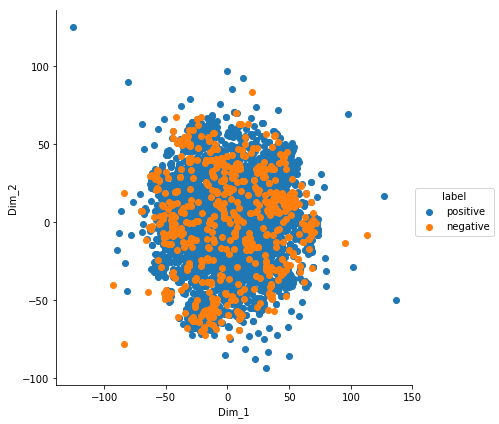

fig 7
tSNE: with default perplexity = 50 & no. of iterations = 5000


In [31]:


model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000) #preplexity changed with no. of iterations
tsne_data = model.fit_transform(B)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
print(' tSNE: with p =50 and number of iterations = 5k')
plt.show()


print('fig 7')
print('tSNE: with default perplexity = 50 & no. of iterations = 5000')




Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

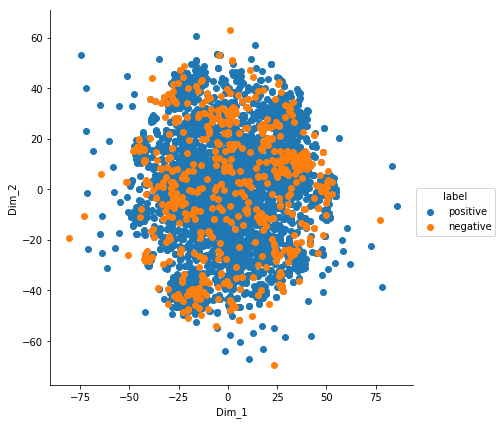

fig 8
tSNE: with default perplexity = 50 & no. of iterations = 1000


In [32]:

model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=1000) #preplexity changed with no. of iterations
tsne_data = model.fit_transform(B)

    # creating a new data frame which help us in ploting the result 

tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

    # Ploting the result of tsne

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 8')
print('tSNE: with default perplexity = 50 & no. of iterations = 1000')


OBSERVATION:
----------------------

We tried plotting the tSNE with different perplexities and differetnt number of iterations..

Result
----------

Still we couldnot seperate the positive and the negative points.So, the result is inconclusive

But one thing we noticed here was that although the plot looks scattered, the points donot overlap that much and we can say which points are negative and which are positive just by looking at the plot because they are of different colours but clearly, we cannot differentiate them using because they are not seperated from each other.

-----------------------------------------------------

In [22]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3988, 99939)
the number of unique words including both unigrams and bigrams  99939


In [23]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[20:40])

some sample features(unique words in the corpus) ['abil rate', 'abl', 'abl actual', 'abl add', 'abl anyth', 'abl assembl', 'abl back', 'abl buy', 'abl carri', 'abl choos', 'abl coffe', 'abl communic', 'abl convinc', 'abl digest', 'abl drink', 'abl eat', 'abl enjoy', 'abl even', 'abl feed', 'abl find']


In [24]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [25]:
print(top_tfidf)

           feature     tfidf
0      cours total  0.210118
1      trap unreal  0.210118
2    pretti stinki  0.210118
3        avail www  0.210118
4     unreal cours  0.210118
5          genocid  0.210118
6        total fli  0.210118
7      fli genocid  0.210118
8     right nearbi  0.210118
9     stinki right  0.210118
10      com victor  0.210118
11  genocid pretti  0.210118
12     victor trap  0.210118
13      www amazon  0.200209
14          victor  0.200209
15          unreal  0.200209
16            trap  0.187726
17          stinki  0.187726
18   product avail  0.187726
19             www  0.179503
20             fli  0.173362
21          nearbi  0.162565
22      amazon com  0.137528
23             com  0.132454
24           total  0.127829


Word to vec:
------------

This technique takes the semantic meaning if word into consideration. It is very simple. Just give it a word and you will get the vector of d-dimension. If two words are similar, Then the correspondin vectors seem to be closer. For example (Vman - Vwoman) || (Vking - vqueen) It learns all relatiomships without being programmed. The more the dimensions, the larger the dimensionality. we need large data to execute it. What is basically does is, it looks at the neighbourhood for similarity.



In [26]:

i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())


In [27]:

print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])




use victor fli bait season cant beat great product
*****************************************************************
['use', 'victor', 'fli', 'bait', 'season', 'cant', 'beat', 'great', 'product']


In [28]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  2559
sample words  ['use', 'fli', 'season', 'cant', 'beat', 'great', 'product', 'avail', 'www', 'amazon', 'com', 'cours', 'total', 'pretti', 'stinki', 'right', 'nearbi', 'receiv', 'shipment', 'could', 'hard', 'wait', 'tri', 'love', 'call', 'instead', 'sticker', 'remov', 'easili', 'daughter', 'design', 'sign', 'print', 'car', 'beauti', 'shop', 'program', 'go', 'lot', 'fun', 'everywher', 'like', 'comput', 'monitor', 'realli', 'good', 'idea', 'final', 'outstand', 'everybodi']


In [30]:
print(w2v_model.wv.most_similar('man'))

[('microwav', 0.9986141324043274), ('picki', 0.9986066818237305), ('chang', 0.9985674023628235), ('glass', 0.9985660910606384), ('pod', 0.9985300898551941), ('let', 0.9985208511352539), ('lamb', 0.9984918832778931), ('clean', 0.9984844923019409), ('interest', 0.9984755516052246), ('cheap', 0.9984650611877441)]


In [31]:
print(w2v_model.wv.most_similar('like'))

[('strong', 0.9949477314949036), ('sweet', 0.9942534565925598), ('spici', 0.9936708211898804), ('cream', 0.9921094179153442), ('favorit', 0.9919009208679199), ('sour', 0.9914475083351135), ('onion', 0.9907086491584778), ('light', 0.9899455904960632), ('realli', 0.9897292256355286), ('bbq', 0.9893566966056824)]


In [32]:
count_vect_feat = count_vect.get_feature_names() # list of words in the BoW
print(count_vect_feat[count_vect_feat.index('like')])

like


Average W2V:
---------

It is basically used for converting sentences to vectors. It takes w2v of different words and adds them, then dividing them by the no of words. It is most proably the simplest way to build a sentence vector.


In [33]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

3988
50


tSNE for Average W2V:
------------

In [34]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(sent_vectors)
print(standardized_data.shape)

(3988, 50)


In [35]:
from sklearn.manifold import TSNE

data_2000 = standardized_data[0:4000,:]
labels_2000 = labels[0:6000]

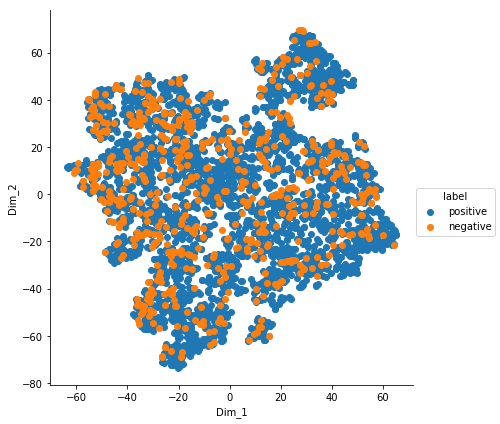

fig 9
 tSNE: with default perplexity & no. of iterations


In [46]:
model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 9')

print(' tSNE: with default perplexity & no. of iterations')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

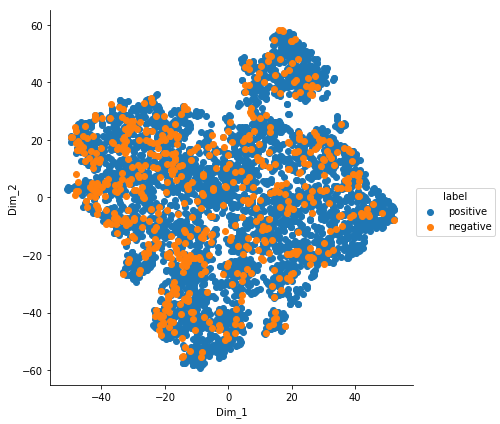

fig 10
tSNE: with default perplexity = 50 & no. of iterations = 2000


In [47]:
model = TSNE(n_components=2, random_state=0, perplexity=50)

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
print('fig 10')
print('tSNE: with default perplexity = 50 & no. of iterations = 2000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

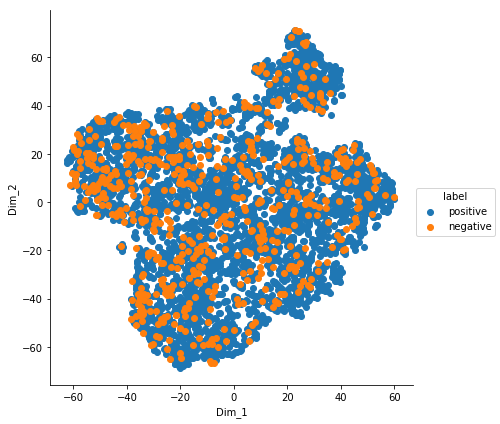

fig 11
tSNE: with default perplexity = 50 & no. of iterations = 5k


In [36]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
print('fig 11')
print('tSNE: with default perplexity = 50 & no. of iterations = 5k')


Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

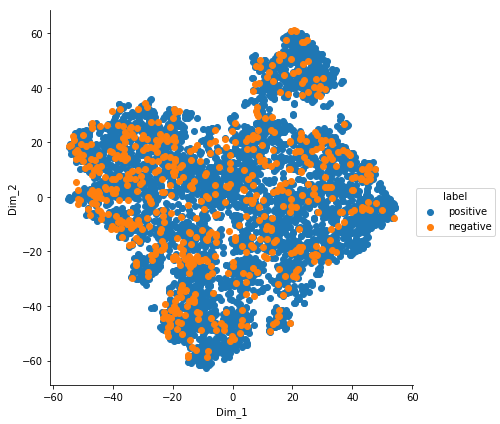

fig 12
tSNE: with default perplexity = 60 & no. of iterations = 25000


In [49]:


model = TSNE(n_components=2, random_state=0, perplexity=60,  n_iter=25000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 12')
print('tSNE: with default perplexity = 60 & no. of iterations = 25000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

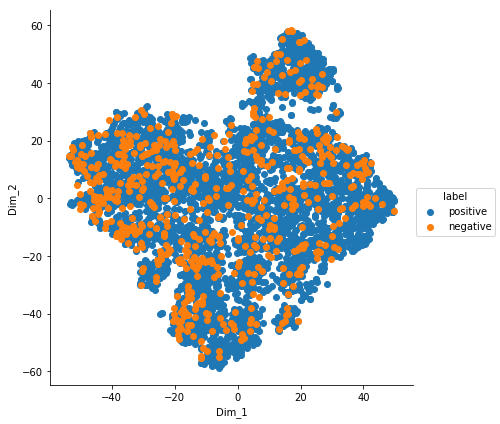

fig 13
tSNE: with default perplexity = 65 & no. of iterations = 75000


In [50]:


model = TSNE(n_components=2, random_state=0, perplexity=65,  n_iter=75000)



tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


print('fig 13')
print('tSNE: with default perplexity = 65 & no. of iterations = 75000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

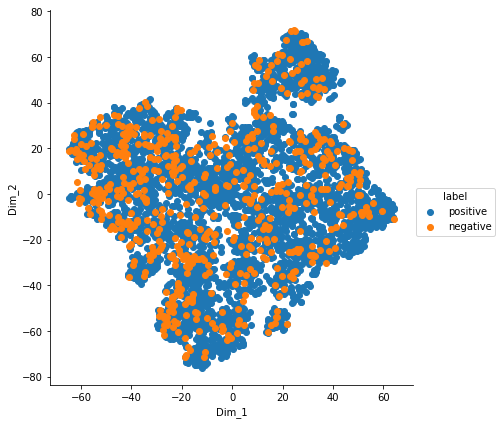

fig 14
tSNE: with default perplexity = 50 & no. of iterations = 105k


In [51]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=105000)


tsne_data = model.fit_transform(data_2000)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()



print('fig 14')
print('tSNE: with default perplexity = 50 & no. of iterations = 105k')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

Conclusion:
-----

We can clearly see that the positive points and the negative points are not seperated even after changing the perplexities

result:
------

What if we reduce the perplexities keeping the no of ite constant, i.e say 105000???....

Let's see



------------

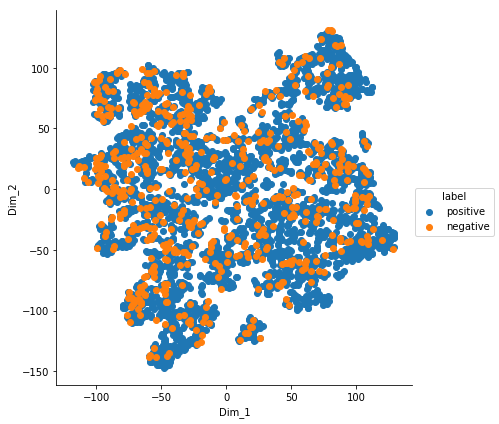

fig 15
tSNE: with default perplexity = 20 & no. of iterations = 105k


In [52]:
model = TSNE(n_components=2, random_state=0, perplexity=20,  n_iter=105000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


print('fig 15')
print('tSNE: with default perplexity = 20 & no. of iterations = 105k')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

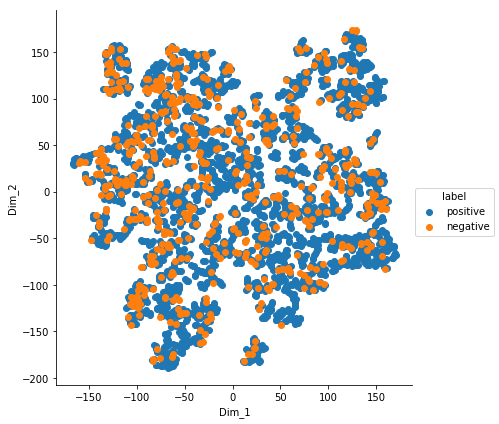

fig 16
tSNE: with default perplexity = 10 & no. of iterations = 105k


In [53]:


model = TSNE(n_components=2, random_state=0, perplexity=10,  n_iter=105000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 16')
print('tSNE: with default perplexity = 10 & no. of iterations = 105k')



Conclusion:
--------

we can observe that keeping perplexities as low as 10 but keeping the no of iterations as high as 105k gives us an invalid result.

Still we couldnot seperate the points.



Result:
--------
let's experiment more then

Now lets check how will it behave when we increase the p keeping the no ite same....


----------------------------------

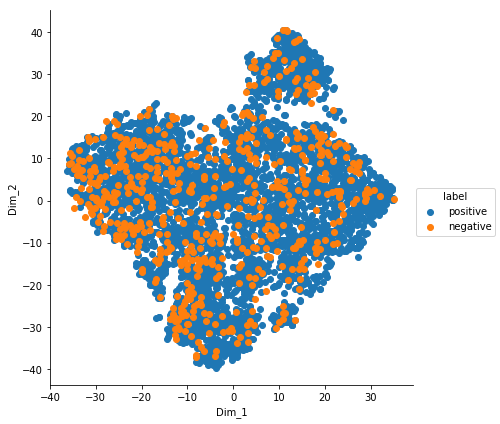

fig 17
tSNE: with default perplexity = 100 & no. of iterations = 5000


In [54]:
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


print('fig 17')
print('tSNE: with default perplexity = 100 & no. of iterations = 5000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

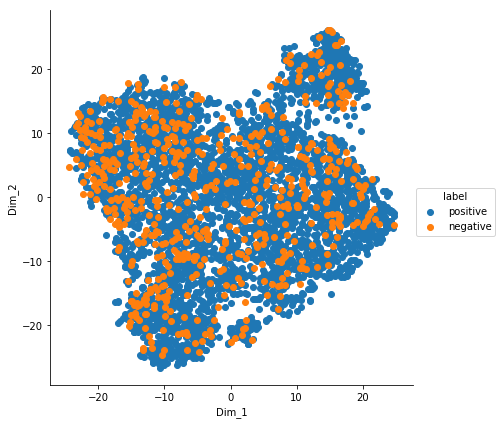

fig 18
tSNE: with default perplexity = `150 & no. of iterations = 5000


In [55]:


model = TSNE(n_components=2, random_state=0, perplexity=150,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


print('fig 18')

print('tSNE: with default perplexity = `150 & no. of iterations = 5000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

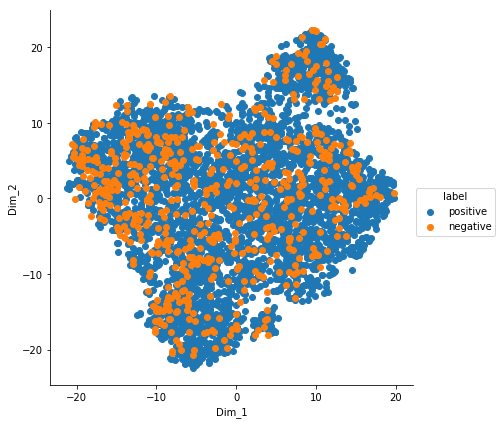

fig 19
tSNE: with default perplexity = 200 & no. of iterations = 5000


In [56]:


model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


print('fig 19')
print('tSNE: with default perplexity = 200 & no. of iterations = 5000')

Observation:
------------

it looks very distorted



-------------------------------------------

TF-IDF weighted Word2Vec:
---

Here we multiply the tf idf values with the w2v of a word.


In [57]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

tSNE of TF-IDF weighted Word2Vec:
-----------------

In [58]:
from sklearn.preprocessing import StandardScaler
standardized_data_one = StandardScaler().fit_transform(tfidf_sent_vectors)
print(standardized_data.shape)

(3988, 50)


In [59]:
from sklearn.manifold import TSNE


data_2000 = standardized_data_one[0:4000,:]
labels_2000 = labels[0:4000]

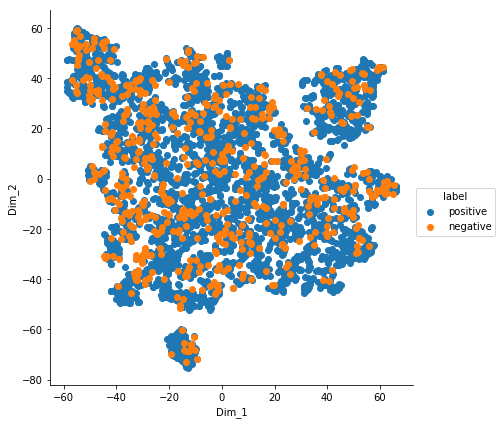

fig 20
tSNE: with default perplexity = 30 & no. of iterations = 2000


In [60]:
model = TSNE(n_components=2, random_state=0)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 2000

tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
print('fig 20')
print('tSNE: with default perplexity = 30 & no. of iterations = 2000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

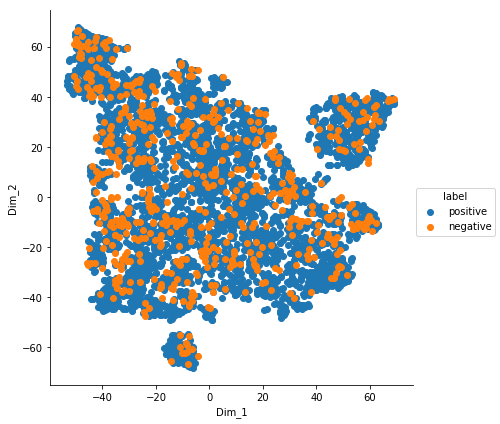

fig 21
tSNE: with default perplexity = 50 & no. of iterations = 5000


In [63]:
model = TSNE(n_components=2, random_state=0, perplexity=50,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 21')

print('tSNE: with default perplexity = 50 & no. of iterations = 5000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

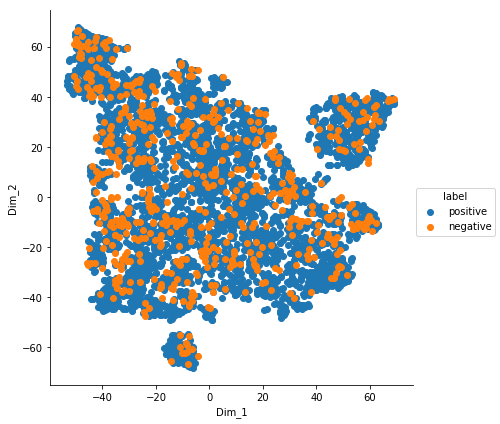

fig 22
tSNE: with default perplexity = 60 & no. of iterations = 105000


In [64]:
tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 22')

print('tSNE: with default perplexity = 60 & no. of iterations = 105000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

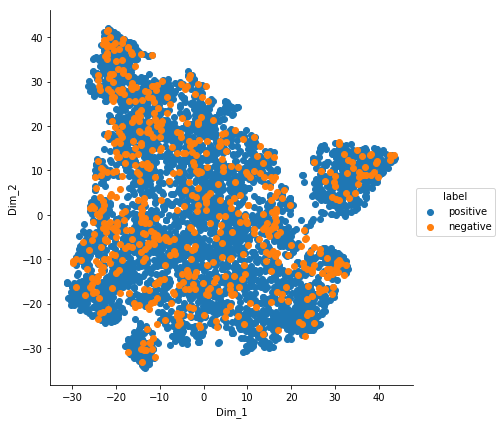

fig 23
tSNE: with default perplexity = 100 & no. of iterations = 5000


In [65]:
model = TSNE(n_components=2, random_state=0, perplexity=100,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()


print('fig 23')
print('tSNE: with default perplexity = 100 & no. of iterations = 5000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

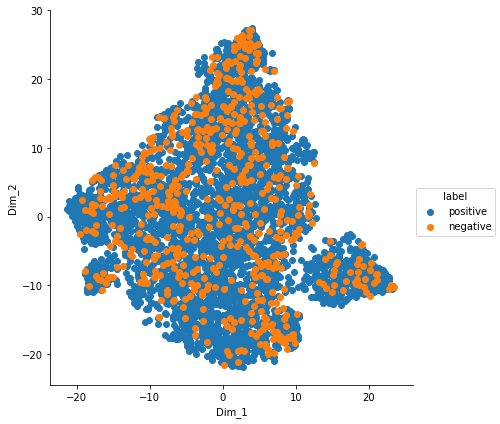

fig 24
tSNE: with default perplexity = 200 & no. of iterations = 105000


In [66]:
model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=105000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 24')

print('tSNE: with default perplexity = 200 & no. of iterations = 105000')

Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

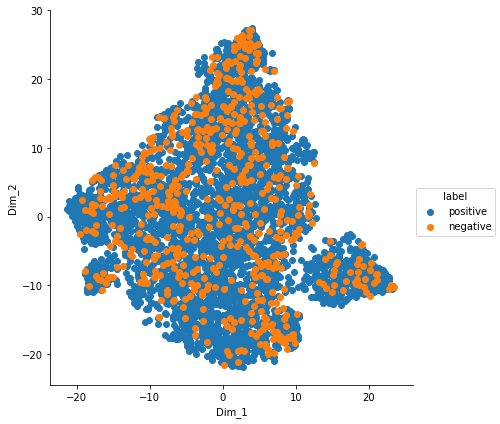

fig 25
tSNE: with default perplexity = 200 & no. of iterations = 5000


In [67]:


model = TSNE(n_components=2, random_state=0, perplexity=200,  n_iter=5000)


tsne_data = model.fit_transform(data_2000)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_2000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

print('fig 25')

print('tSNE: with default perplexity = 200 & no. of iterations = 5000')


Observation:
----

All points are scatterd and we can't differentiate between the positive and the negative points.

Conclusion:
----------

We tried plotting the tSNE of BoW, tf-idf, Avg W2V and TF-IDF weighted Word2Vec. But we did not get a plot which helped us differentiate between the positive and the negative points clearly. We tried plotting on several perplexities and several no of iterations but we didnot get any plot which seperated the positive and the negative points.

-----------------------------------------------------------------------------

We could have gotten a different result if we had taken more reviews but due to the inability of our system to manage RAM, we had to take 4k reviews. 

Had we taken more reviews, the results could have been different....
